In [1]:
import jax.numpy as np
import numpy.random as npr
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.experimental import optimizers
import jax.random as jnp_random
from jax.lax import scan
from jax.scipy.special import logsumexp
from IPython.display import clear_output
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
n = 10
key = jnp_random.PRNGKey(0) 

@jit
def f(x, u):
    xnew = x + np.tanh(u)
    return xnew, x

_pts = jnp_random.uniform(key, shape=(3, n), minval=-1, maxval=1)
_pts = np.stack([np.ones(n)*0.5, -np.ones(n)*0.5])
_w = np.array([0.5, 0.5])
# _pts = np.ones(n)*0.6
def p(x):
    dx = x - _pts
    return np.dot(_w, np.exp(-0.5*np.mean((dx/0.2)**2, axis=1)))

@jit
def dist(x, s):
    dx = x-s
    return -0.5 * np.sum((dx/0.1)**2)

logexp_vmap = lambda _x, _s: logsumexp(vmap(dist, in_axes=(0, None))(_x, _s))

@jit
def loss(u, x0, si, xT=False):
    xf, tr = scan(f, x0, u)
    ell = -np.mean(vmap(partial(logexp_vmap, tr))(si) * vmap(p)(si)) + 1e-3*np.mean(u**2)#+ np.mean(vmap(p)(si) * np.log(vmap(p)(si)))
    if xT:
        return ell, tr 
    return ell

dl = jit(grad(loss))
# dlsi = jit(grad(loss, 2))

/home/burn/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
key, subkey = jnp_random.split(key)
x0 = jnp_random.normal(subkey, shape=(n,))*0.2
u = np.zeros((100,n))

key, subkey = jnp_random.split(key)
si = jnp_random.uniform(key, minval=-1, maxval=1, shape=(100,n))

# x_test, y_test = np.meshgrid(*[np.linspace(-1,1)]*2)
# map_pts = np.stack([x_test.ravel(), y_test.ravel()]).T
loss(u, x0, si)


opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(u)

In [4]:
x = np.linspace(-1,1)
pdf = vmap(p)(x)

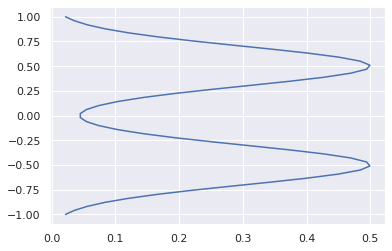

In [5]:
plt.plot(pdf, x)

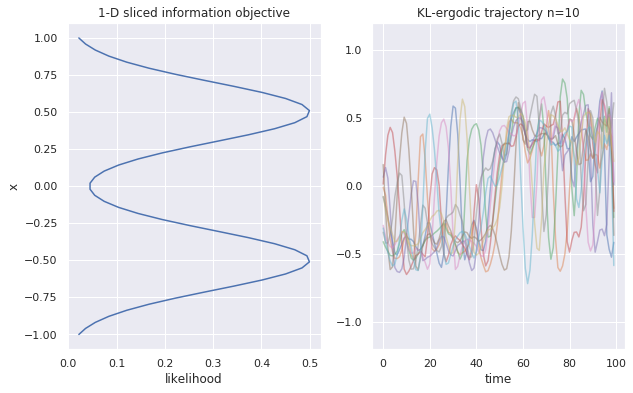

In [7]:
log = []
i = 0
for k in range(5000):
#     xf, tr = scan(f, x0, u)
    key, subkey = jnp_random.split(key)
    si = jnp_random.uniform(key, minval=-1, maxval=1, shape=(100,n))
    g = dl(get_params(opt_state), x0, si)
#     u -= 0.5 * dl(u, x0, si)
    opt_state = opt_update(k, g, opt_state)
    
    if (k+1) % 100 == 0:
        u = get_params(opt_state)
        log.append(loss(u, x0, si).copy())
        clear_output(wait=True)
        xf, tr = scan(f, x0, u)
        fig, axs = plt.subplots(1, 2, figsize=(10,6))
        axs[1].plot(tr, alpha=0.5)
        axs[0].plot(pdf, x)
        axs[0].set_title('1-D sliced information objective')
        axs[0].set_xlabel('likelihood')
        axs[1].set_xlabel('time')
        axs[0].set_ylabel('x')
        axs[1].set_title('KL-ergodic trajectory n=10')
        plt.ylim(-1.2,1.2)
#         plt.legend()
        plt.savefig('./tmp/kle-{:04}.png'.format(k))
        plt.pause(0.001)
        i+=1
#         plt.show()


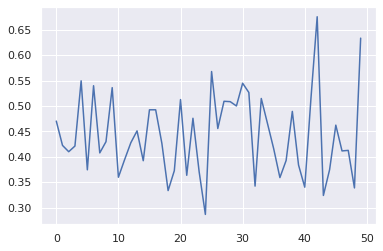

In [8]:
plt.plot(log)

In [8]:
np.mean(tr, axis=0)

DeviceArray([ 0.00016315, -0.04356546,  0.03085767,  0.04288203,
              0.02436592,  0.04941477,  0.00953734,  0.02402818,
              0.05017351,  0.04813238], dtype=float32)

In [9]:
from matplotlib import rc
rc('text', usetex=True)

NameError: name 'pred_tr' is not defined

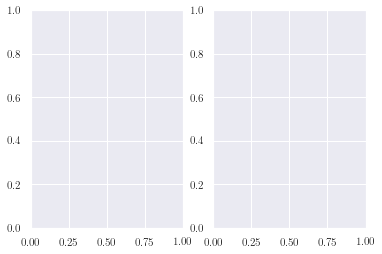

In [10]:
    
fig, ax = plt.subplots(1, 2)
recon = np.exp(vmap(partial(logexp_vmap, pred_tr))(map_pts))
ax[0].contourf(x_test, y_test, pdf, cmap='bone')
ax[1].contourf(x_test, y_test, recon.reshape(x_test.shape), cmap='bone')

ax[1].plot(pred_tr[:,0], pred_tr[:,1], 'm')
ax[0].plot(pred_tr[:,0], pred_tr[:,1], 'm')
ax[0].set_title('Exploration space')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('KL time-average reconstruction')
ax[0].axis('equal')
ax[0].axis('square')
ax[1].axis('equal')
ax[1].axis('square')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
plt.tight_layout()

plt.savefig('kl-ergodic-coverage.pdf') 

In [47]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = onp.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = onp.searchsorted(cumulative_sum, npr.random(N))
    
    indexes = npr.choice(len(particles), size=(len(particles),), p=weights)
    # weights.fill(1.0 / N)
    return particles[indexes]

In [188]:
si = simple_resample(si, weights)
si += npr.normal(0., 0.1, size=si.shape)

weights = vmap(p)(si)
weights /= np.sum(weights)

IndexError: index 15 is out of bounds for axis 0 with size 10

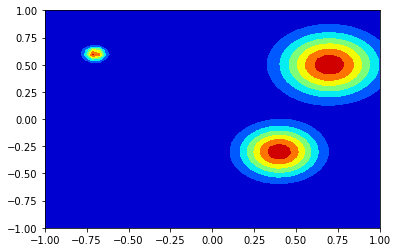

In [255]:

plt.contourf(x_test, y_test, pdf, cmap='jet')
plt.scatter(si[idxs,0], si[idxs,1])

In [2]:
import torch
from torch.autograd.functional import jacobian

In [23]:
def f(x, y):
    return x.exp() + torch.pow(y, 2)

inputs = (torch.rand(3,2), torch.rand(3,2))

jacobian(f, inputs)[0].shape

torch.Size([3, 2, 3, 2])